In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load and prepare data
def load_and_split_data():
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_and_split_data()

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'GradientBoosting': GradientBoostingClassifier()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 10, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    }
}

In [5]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

def plot_conf_matrix(model, X_test, y_test, title="Confusion Matrix"):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc(model, X_test, y_test, label):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    return roc_auc

In [6]:
results = []
best_models = {}

for name in models:
    print(f"\n🔍 GridSearchCV for {name}")
    grid = GridSearchCV(models[name], param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    res = evaluate_model(name, best_model, X_test_scaled, y_test)
    results.append(res)
    print(f"✅ Best Parameters: {grid.best_params_}")
    print("📊 Classification Report:")
    print(classification_report(y_test, best_model.predict(X_test_scaled)))


🔍 GridSearchCV for RandomForest
✅ Best Parameters: {'max_depth': 10, 'n_estimators': 100}
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


🔍 GridSearchCV for SVC
✅ Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


🔍 GridSearchCV for GradientBoosting
✅ Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
📊 

In [7]:
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n🔝 Model Evaluation Summary")
print(results_df.to_string(index=False))


🔝 Model Evaluation Summary
           Model  Accuracy  Precision   Recall  F1-Score
             SVC  0.982456   0.972603 1.000000  0.986111
    RandomForest  0.964912   0.958904 0.985915  0.972222
GradientBoosting  0.956140   0.958333 0.971831  0.965035



🎯 Best model is: SVC


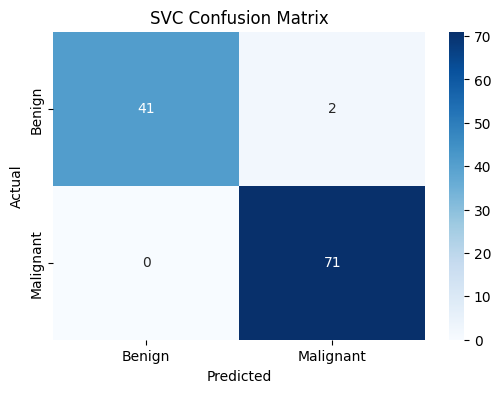

In [8]:
best_model_name = results_df.iloc[0]['Model']
best_model = best_models[best_model_name]

print(f"\n🎯 Best model is: {best_model_name}")
plot_conf_matrix(best_model, X_test_scaled, y_test, f"{best_model_name} Confusion Matrix")

📈 ROC Curve Comparison


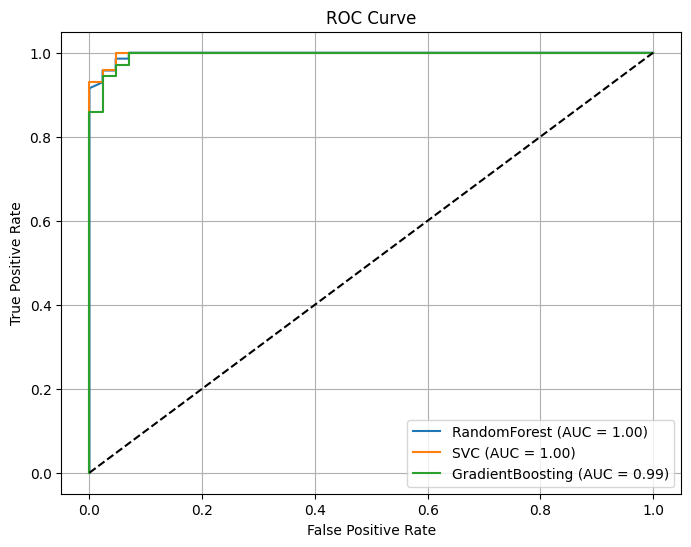

In [9]:
print("📈 ROC Curve Comparison")
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    plot_roc(model, X_test_scaled, y_test, name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


🎲 Running RandomizedSearchCV for SVC
📌 RandomizedSearchCV Best Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



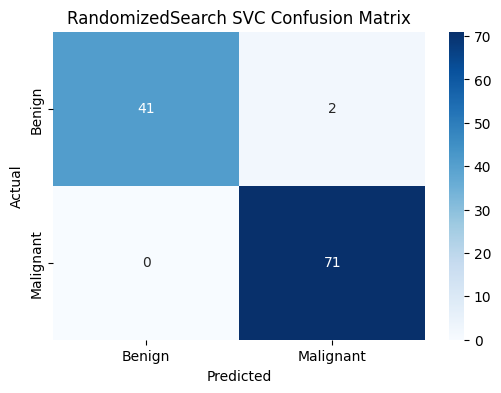

In [10]:
print("\n🎲 Running RandomizedSearchCV for SVC")
random_search = RandomizedSearchCV(
    SVC(probability=True),
    param_distributions=param_grids['SVC'],
    n_iter=5,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)
print(f"📌 RandomizedSearchCV Best Params: {random_search.best_params_}")
print("📊 Classification Report:")
print(classification_report(y_test, random_search.predict(X_test_scaled)))
plot_conf_matrix(random_search.best_estimator_, X_test_scaled, y_test, "RandomizedSearch SVC Confusion Matrix")